In [1]:
from pedigree_functions import *
import matplotlib.pyplot as plt
import scipy.stats as stats

C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [2]:
#set up and simulation for 1 chromosome
#requires: genomic map, SNP positions, parent genotypes
#builds: arbitrary pedigree, founder nodes
#simulates: ARG based on pedigree and genomic map, offspring genotypes of pedigree based on ARG and parent genotypes

#simulate genotypes of one population combination (e.g. pop 1 (B73×B97)S5)
#sim ancestry with pedigree similar to pop (~150 offspring + 5 selfing genos)

#load genmap chr1 or load entire genmap and use chr column to reduce -> in full script loop over chr and concat geno_sims
genmap = pd.read_csv("data/test_data/B73_genmap_chr1.csv")
chr1_rate_map = get_rate_map(genmap)

#set up pedigree
pop_1_ped_df = pedigree_init(n = 2) 
pop_1_ped_df = add_selective_mating(pop_1_ped_df, list([0,1]), offspring = 194)
for i in range(0, 5):
    pop_1_ped_df = add_selfing(pop_1_ped_df)
pop_1_ped = df_to_ts(pop_1_ped_df, seq_len=297570924)

#load snp positions
SNP_positions = pd.read_csv("data/test_data/NAM_SNP_positions.csv")

#reduce SNPs to chr1 of genetic map
chr_1_SNP_positions = SNP_positions[SNP_positions["Marker"].isin(genmap["Marker"])]

#read parent genotypes
parent_genos = pd.read_csv("data/test_data/NAM_parent_genos.csv")

#choose which parents to cross
founder_nodes = get_founder_nodes(parent_genos, list(["B73", "B97"]))

#simulate chromosome 1
chr1_arg = msprime.sim_ancestry(initial_state = pop_1_ped, model="fixed_pedigree", recombination_rate = chr1_rate_map)

#propagate ARG recombinations to offspring genotypes
geno_sim = propagate_geno(chr1_arg, founder_nodes, chr_1_SNP_positions)

#join haploid offspring simulation nodes to diploid individuals
genotypes = join_nodes(chr1_arg, geno_sim)

#read reference allele
ref_allele = pd.read_csv("data/test_data/B73_alleles.csv")

#reduce ref_alleles to alleles in genmap
ref_allele = ref_allele[ref_allele["SNP"].isin(genmap["Marker"])]

#recode genotype values into additive encoding
geno_add = additive_encoding(ref_allele, genotypes)


##add function to automate pedigree set up params chromosome length
##turn entire into one inner loop per chromosome
##outer loop concat chromosomes (concat geno_add dfs)

In [ ]:
#read genetic map
genmap = pd.read_csv("data/test_data/B73_genmap.csv")
#load snp positions
SNP_positions = pd.read_csv("data/test_data/NAM_SNP_positions.csv")
#read parent genotypes
parent_genos = pd.read_csv("data/test_data/NAM_parent_genos.csv")
#read reference allele
ref_allele = pd.read_csv("data/test_data/B73_alleles.csv")

def genotype_simulation(genetic_map, SNP_positions, parent_genos, ref_allele, founder_list)
    
    founder_nodes = get_founder_nodes(parent_genos, founder_list)

    #reduce ref_alleles to alleles in genmap
    ref_allele = ref_allele[ref_allele["SNP"].isin(genmap["Marker"])]
    
    genotypes
    #for i in range(#chromosomes)
        #set up pedigree with chromosome length
        chr1_rate_map = get_rate_map(genmap)
        #reduce SNPs to chr1 of genetic map
        chr_1_SNP_positions = SNP_positions[SNP_positions["Marker"].isin(genmap["Marker"])]
    
        #simulate chromosome 1
        chr1_arg = msprime.sim_ancestry(initial_state = pop_1_ped, model="fixed_pedigree", recombination_rate = chr1_rate_map)
        
        #propagate ARG recombinations to offspring genotypes
        geno_sim = propagate_geno(chr1_arg, founder_nodes, chr_1_SNP_positions)
        
        #join haploid offspring simulation nodes to diploid individuals
        genotypes = join_nodes(chr1_arg, geno_sim)
        pd.concat(genotypes, genotypes_chrX)
    
    genotypes_additive = additive_encoding(ref_allele, genotypes)

    return(genotypes_additive)

In [3]:
print(chr1_arg.dump_tables())

TableCollection

Sequence Length: 297570924.0
Time units: generations
Metadata: b''

Individuals
╔════╤═════╤════════╤════════╤═══════════════════╗
║id  │flags│location│parents │metadata           ║
╠════╪═════╪════════╪════════╪═══════════════════╣
║0   │    0│        │  -1, -1│   {'file_id': '0'}║
║1   │    0│        │  -1, -1│   {'file_id': '1'}║
║2   │    0│        │    0, 1│   {'file_id': '2'}║
║3   │    0│        │    0, 1│   {'file_id': '3'}║
║4   │    0│        │    0, 1│   {'file_id': '4'}║
║5   │    0│        │    0, 1│   {'file_id': '5'}║
║6   │    0│        │    0, 1│   {'file_id': '6'}║
║7   │    0│        │    0, 1│   {'file_id': '7'}║
║8   │    0│        │    0, 1│   {'file_id': '8'}║
║9   │    0│        │    0, 1│   {'file_id': '9'}║
║10  │    0│        │    0, 1│  {'file_id': '10'}║
║11  │    0│        │    0, 1│  {'file_id': '11'}║
║12  │    0│        │    0, 1│  {'file_id': '12'}║
║13  │    0│        │    0, 1│  {'file_id': '13'}║
║14  │    0│        │    0, 1│  {'fi

In [4]:
chr1_argm = msprime.sim_mutations(chr1_arg, rate = 0.00000001)

In [5]:
print(chr1_argm.dump_tables())

TableCollection

Sequence Length: 297570924.0
Time units: generations
Metadata: b''

Individuals
╔════╤═════╤════════╤════════╤═══════════════════╗
║id  │flags│location│parents │metadata           ║
╠════╪═════╪════════╪════════╪═══════════════════╣
║0   │    0│        │  -1, -1│   {'file_id': '0'}║
║1   │    0│        │  -1, -1│   {'file_id': '1'}║
║2   │    0│        │    0, 1│   {'file_id': '2'}║
║3   │    0│        │    0, 1│   {'file_id': '3'}║
║4   │    0│        │    0, 1│   {'file_id': '4'}║
║5   │    0│        │    0, 1│   {'file_id': '5'}║
║6   │    0│        │    0, 1│   {'file_id': '6'}║
║7   │    0│        │    0, 1│   {'file_id': '7'}║
║8   │    0│        │    0, 1│   {'file_id': '8'}║
║9   │    0│        │    0, 1│   {'file_id': '9'}║
║10  │    0│        │    0, 1│  {'file_id': '10'}║
║11  │    0│        │    0, 1│  {'file_id': '11'}║
║12  │    0│        │    0, 1│  {'file_id': '12'}║
║13  │    0│        │    0, 1│  {'file_id': '13'}║
║14  │    0│        │    0, 1│  {'fi

In [3]:
geno_add

SNP,PHM12706.14,PHM1275.22,PHM13619.5,PHM14475.7,PHM15871.11,PHM16605.19,PHM18705.23,PHM1968.22,PHM2244.142,PHM2478.22,...,PZB01647.1,PZB01662.1,PZB01957.1,PZB02058.1,an1.5,csu1171.2,glb1.2,kip1.3,umc128.2,umc13.1
individual,,,,,,,,,,,,,,,,,,,,,
972,2,0,0,2,2,2,0,0,0,0,...,1,0,0,0,0,0,2,2,0,0
973,2,0,0,0,2,0,0,0,2,0,...,0,2,0,0,2,0,0,0,0,2
974,0,0,2,0,0,0,0,0,0,0,...,0,2,2,0,2,0,0,0,0,2
975,2,2,0,2,2,2,0,0,2,2,...,2,0,0,0,2,0,2,2,0,0
976,0,2,2,0,0,0,0,0,2,0,...,0,2,2,0,2,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2,2,2,2,2,2,0,0,2,2,...,2,0,0,0,2,0,2,2,0,0
1162,0,2,0,2,2,2,0,0,2,2,...,2,0,0,0,0,0,2,2,0,0
1163,2,2,0,2,2,2,0,0,0,2,...,2,0,0,0,2,0,2,2,0,0


In [4]:
genotypes

,individual,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA02359.10,PHM9807.9,PZA01068.1,PZA00343.31,PHM1275.22,PZA00243.25,PZA00856.2,PZA01239.2,PZA01807.1,PZA00432.4
0,972,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,TT,CC,CC,AA,AA,GG,TT,AA,GG,CC
1,973,GG,TT,CC,AA,GG,TT,AA,TT,CC,...,TT,CC,CC,AA,AA,GG,TT,AA,GG,CC
2,974,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,TT,CC,CC,AA,AA,GG,TT,AA,GG,CC
3,975,GG,TT,CC,AA,GG,TT,AA,TT,CC,...,TT,GG,CC,GG,CC,AA,TT,AA,GG,TT
4,976,GG,TT,CC,AA,GG,TT,AA,TT,CC,...,TT,GG,CC,GG,CC,AA,TT,AA,GG,TT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,1161,GG,TT,CC,AA,GG,TT,AA,TT,CC,...,TT,GG,CC,GG,CC,AA,TT,AA,GG,TT
190,1162,GG,TT,CC,AA,GG,TT,AA,GG,AA,...,TT,GG,CC,GG,CC,AA,TT,AA,GG,TT
191,1163,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,TT,GG,CC,GG,CC,AA,TT,AA,GG,TT
192,1164,GG,TT,CC,AA,CG,TT,AA,TT,CC,...,TT,CC,CC,AA,AA,GG,TT,AA,GG,CC


In [5]:
pd.Series(geno_add.values.flatten().tolist()).value_counts()

0    20875
2     9180
1      597
Name: count, dtype: int64

In [6]:
geno_add.sum(axis = 1).mean()

97.71649484536083

In [7]:
geno_add.sum(axis = 1).var()

2228.463249826398

<Axes: ylabel='Density'>

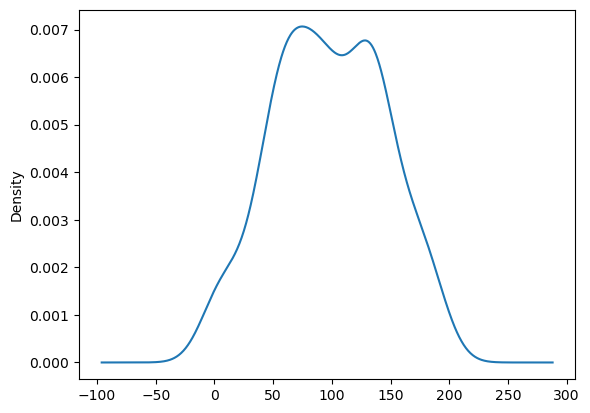

In [8]:
geno_add.sum(axis = 1).plot.kde()

In [9]:
stats.kstest(geno_add.sum(axis = 1), "norm")

KstestResult(statistic=0.9780315452673389, pvalue=4.05e-322, statistic_location=3, statistic_sign=-1)

(array([0.00295318, 0.00161082, 0.0064433 , 0.00778565, 0.00671177,
        0.0064433 , 0.00805412, 0.00563789, 0.00295318, 0.00349012]),
 array([  0. ,  19.2,  38.4,  57.6,  76.8,  96. , 115.2, 134.4, 153.6,
        172.8, 192. ]),
 <BarContainer object of 10 artists>)

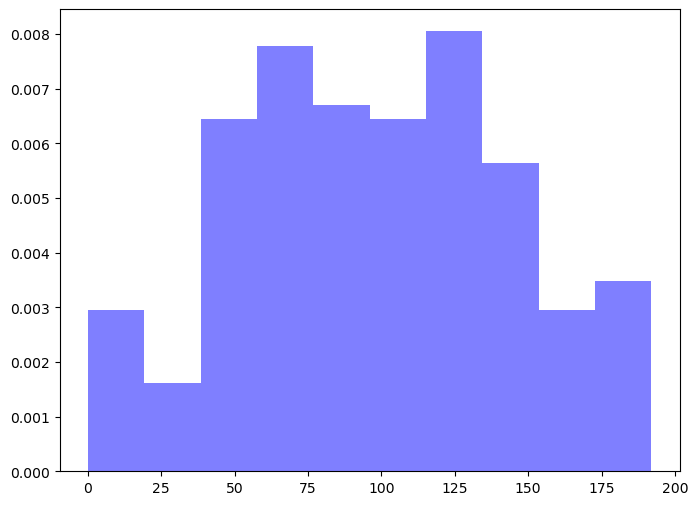

In [10]:
#plt density of additive genotypes
plt.figure(figsize = (8,6))
plt.hist(geno_add.sum(axis = 1), bins = 10, density = True, alpha = 0.5, color = "b")

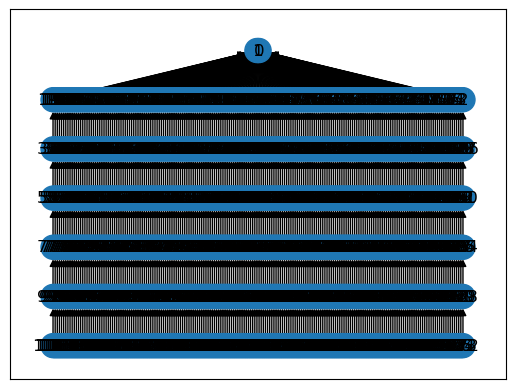

In [113]:
#results
draw_pedigree(pop_1_ped.tree_sequence())

In [5]:
print(chr1_arg.dump_tables())

TableCollection

Sequence Length: 297570924.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤═════════════════╗
║id│flags│location│parents│metadata         ║
╠══╪═════╪════════╪═══════╪═════════════════╣
║0 │    0│        │ -1, -1│ {'file_id': '0'}║
║1 │    0│        │ -1, -1│ {'file_id': '1'}║
║2 │    0│        │   0, 1│ {'file_id': '2'}║
║3 │    0│        │   0, 1│ {'file_id': '3'}║
║4 │    0│        │   0, 1│ {'file_id': '4'}║
║5 │    0│        │   2, 2│ {'file_id': '5'}║
║6 │    0│        │   3, 3│ {'file_id': '6'}║
║7 │    0│        │   4, 4│ {'file_id': '7'}║
║8 │    0│        │   5, 5│ {'file_id': '8'}║
║9 │    0│        │   6, 6│ {'file_id': '9'}║
║10│    0│        │   7, 7│{'file_id': '10'}║
║11│    0│        │   8, 8│{'file_id': '11'}║
║12│    0│        │   9, 9│{'file_id': '12'}║
║13│    0│        │ 10, 10│{'file_id': '13'}║
║14│    0│        │ 11, 11│{'file_id': '14'}║
║15│    0│        │ 12, 12│{'file_id': '15'}║
║16│    0│        │ 13, 13│{'

In [26]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [83]:
# Reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [86]:
#population one genotypes and allele frequencies
pop_1_genos = pd.read_csv("data/test_data/pop_1_genos.csv")
pop_1_chr_1 = pop_1_genos[pop_1_genos.columns.intersection(genmap["Marker"])]
#pop_1_chr_1 = pop_1_chr_1.values.astype(int).tolist()
#pop_1_chr_1_allele_freq = calc_allele_freq(pop_1_chr_1)

#pop_1_chr_1_allele_freq

In [87]:
pop_1_chr_1

,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,...,PZA02359.10,PHM9807.9,PZA01068.1,PZA00343.31,PHM1275.22,PZA00856.2,PZA00243.25,PZA01239.2,PZA01807.1,PZA00432.4
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0
1,2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2,2,2,1.0,1.0,0
2,0,0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2,2,2,2.0,2.0,2
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2,2,2,2.0,2.0,2
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2,2,2,2.0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0
190,0,0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0
191,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2,2,2,2.0,2.0,2
192,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0,0,0,0.0,0.0,0


In [90]:
pop_1_chr_1.sum(axis = 1).mean()

161.97938144329896

In [89]:
pop_1_chr_1.sum(axis = 1).var()

5183.041023449602

<Axes: ylabel='Density'>

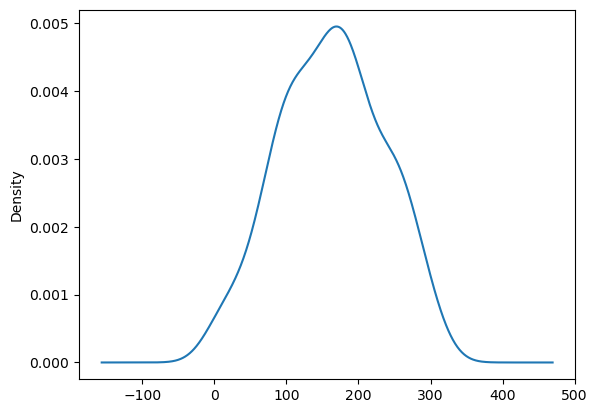

In [108]:
pop_1_chr_1.sum(axis = 1).plot.kde()

In [111]:
stats.kstest(pop_1_chr_1.sum(axis = 1), "norm")

KstestResult(statistic=0.9896907216494846, pvalue=0.0, statistic_location=11.0, statistic_sign=-1)

In [63]:
pop_1_chr_1.sum(axis = 1).value_counts()

134    4
248    3
135    3
154    3
262    3
85     3
106    3
245    3
114    2
159    2
100    2
171    2
164    2
170    2
120    2
239    2
13     2
197    2
104    2
206    2
89     2
184    2
39     2
33     2
124    2
281    2
195    2
217    2
295    2
150    2
0      2
297    2
213    2
77     2
97     2
275    2
158    2
173    2
98     2
181    2
254    2
182    2
71     2
204    2
189    2
163    2
198    2
37     1
172    1
102    1
56     1
252    1
11     1
87     1
238    1
210    1
177    1
119    1
153    1
259    1
76     1
211    1
112    1
50     1
169    1
155    1
207    1
215    1
55     1
241    1
92     1
203    1
103    1
180    1
274    1
130    1
243    1
174    1
95     1
222    1
91     1
96     1
244    1
183    1
69     1
78     1
74     1
284    1
179    1
110    1
142    1
185    1
151    1
12     1
272    1
186    1
178    1
253    1
66     1
137    1
63     1
166    1
144    1
122    1
145    1
49     1
221    1
216    1
225    1
162    1
116    1
1

In [106]:
pd.Series(pop_1_chr_1.values.flatten().tolist()).value_counts()

2.0    14224
0.0    13451
1.0     2387
0.5      296
1.5      294
Name: count, dtype: int64

(array([0.00098811, 0.00148216, 0.0032937 , 0.00461118, 0.00428181,
        0.00576397, 0.00444649, 0.00296433, 0.00279964, 0.00131748]),
 array([  0. ,  31.3,  62.6,  93.9, 125.2, 156.5, 187.8, 219.1, 250.4,
        281.7, 313. ]),
 <BarContainer object of 10 artists>)

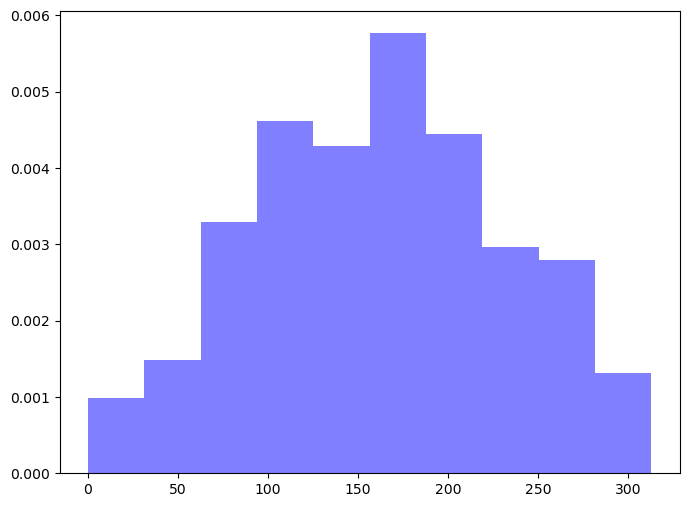

In [112]:
#plt density of additive genotypes
plt.figure(figsize = (8,6))
plt.hist(pop_1_chr_1.sum(axis = 1), bins = 10, density = True, alpha = 0.5, color = "b")

In [ ]:
#calculate rogers and neis distance between real pop and simulated pop
#calculate allele frequencies
def calc_allele_freq(matrix, alleles = 3):
    num_individuals = len(matrix)
    num_snps = len(matrix[0])
    num_alleles = alleles
    allele_frequencies = []

    for j in range(num_snps):
        allele_counts = [0] * num_alleles

        for i in range(num_individuals):
            allele_counts[matrix[i][j]] += 1

        snp_frequencies = [count / num_individuals for count in allele_counts]
        allele_frequencies.extend(snp_frequencies)

    return allele_frequencies

#rogers distance

#neis distance
def neis_distance(X):
    #matrix product of X and its transpose
    d = np.matmul(X, X.T)
    
    #sqrt of diagonal elements
    vec = np.sqrt(np.diag(d))
    
    #Normalize columns of d
    d /= vec[:, np.newaxis]
    
    #Normalize rows of d
    d /= vec
    
    #negative logarithm
    d = -np.log(d)
    
    #todistance matrix
    d = np.asarray(d)
    
    return d

In [24]:
#examples for neis distance and allele frequency functions
X = np.array([[1.0, 3.0, 5.0], [2.0, 4.0, 6.0]])

In [25]:
X

array([[1., 3., 5.],
       [2., 4., 6.]])

In [25]:
neis_distance(X)

array([[-0.        ,  0.00616024],
       [ 0.00616024, -0.        ]])

In [50]:
#example (max distance of pop with 4 individauls vs 3 individuals)
matrix_1 = [
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
]
matrix_2 = [
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [0, 1, 1, 1]
]

freq_1 = calculate_allele_frequency(matrix_1)
freq_2 = calculate_allele_frequency(matrix_2)
print(freq_2)

[0.3333333333333333, 0.6666666666666666, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]


In [51]:
X = np.array(list([freq_1, freq_2]))

In [52]:
neis_distance(X)

array([[-0.        ,  2.42601513],
       [ 2.42601513, -0.        ]])